<div style="text-align:center; padding-top:10px; padding-bottom:20px">
    <font color='darkpink'><center><h1>Upgrading Amenities: <br> An Application of Recommender Systems in Airbnb Listings</h1><center/></font>
    </div>
<div style="text-align:center">
    <b>Big Data and Cloud Computing Final Project</b><br>
    <b>LT6: Buno, Medina, Ongleo</b>
</div>

## Executive Summary
<br>
<div align='justify'>Airbnb is an online marketplace for users to find lodging or rentals for short-term vacations to even long-term stays. It has a total of 150 million users worldwide with around 2 million people staying on an Airbnb per night. Catering to this demand, there are over 6 million Airbnb listings for users to choose from. More and more hotel owners to small-time apartment owners are shifting to this medium in looking for their next customer. With that, listings are getting more and more competitive to become more attractive to Airbnb users. </div>
<br>
<div align='justify'>
This study aims to find which amenities should owners/hosts need to add to their Airbnb properties to become more competitive in their different segments. Using the Inside Airbnb dataset available in jojie filtered to listings only, we looked into clustering the listings based on the different features such as number of bedrooms, property type, etc. and recommend what amenities are most needed to increase the value of the property per cluster. The data consists of listings from 2015 to 2019 amounting to about 16 million rows with 106 features, comprising a total of 85GB.
</div>

K-Means algorithm was used in performing the clustering of listings. Eight (8) clusters were identified based on the validation criterias and clustering are based on the type and size of the listings. The clusters obtained are the following indicating their characteristics: 
   - Cluster 0: Lower-middle end
   - Cluster 1: Middle end (entire home)
   - Cluster 2: Upper-middle end
   - Cluster 3: Low end
   - Cluster 4: Middle end (Private rooms)
   - Cluster 5: Ultra high end
   - Cluster 6: Ultra low end
   - Cluster 7: High end

<div align='justify'>
After obtaining the clusters, user-based collaborative filtering was then used to make recommendations of amenities per cluster. However, what makes this system different is that it recommends amenities to the low-rated listings using the similar listings but with high rating. This is to find what the low-rated listings are missing that the high-rated listings have. Doing this would also help the owners address customer convenience, increase its listing's popularity, and further understand what the customers really needs.
</div>

Results of the recommender system showed that what the low-rated listings are lacking are not necessarily the most commonly needed amenities but the very much desired ones. Some of which includes `Wifi`, `hair dryer`, and `iron`, and the `essentials` which are known to be always being used when going on a vacation or a trip. This possibly is the reason why they are being low-rated. 

For future studies, we recommend to extend this study to be a general recommender system which can cater listings from different countries or city, especially those which are not commonly visited by tourists. This is to help them improve their listings by adding necessary amenities mostly wanted by the customers. A monetary value of every amenity being added could also be explored by predicting the price or rating of the listing after implementing the recommended amenity. 

## Introduction

### Why Airbnb?
`Airbnb` is the world's largest accomodation-sharing website which lets 'hosts' rent out their properties to guests. It has been growing rapidly since its launch in 2009 where it only served **around 20,000 guests that year to around 500,000 guests per night**. This amount of users is not only a testament to how many people Airbnb is able to help but also to how much potential it has as a business. As of December 2019, Airbnb's value worldwide is 38 USD billion and grossing around 93 USD million in profit per year.

### Why Listings?
`Listings` are the product of Airbnb. It is every house, apartment and hotel room that you see posted in their website. These listings cater to each of the 150 million customers worldwide. Given this market, it is to no surprise that property owners would want to become Airbnb hosts. Currently, Airbnb has around **650,000 hosts in over 191 countries** and each of these hosts earn an average of 11,000 dollars per year. 

### Why Paris?
For the interest of this project, the data was segmented only to listings located in `Paris, France`. The city of love is one of the most famous tourist spots there is and perhaps because of that, **houses the most number of listings in a single city**. Though this study is specific for Paris, the methodology should work for any city and thus, tweak the recommender to cater for any city.

### Problem Statement
With such a competitive market, hosts strive to make their listings better to keep their ratings, prices, and ultimately, their profit higher. One way to do this is by adding more amenities such as television, couch, or a bathtub. However, which amenities would give them the largest jump in value?
<br>
**Which amenities should they add to their properties to increase the competitiveness of their Airbnb listings?**

## Data

<br>
<div align='justify'>The dataset used in this study is the Inside Airbnb data obtained from <a href='www.insideairbnb.com'>Inside Airbnb site</a>. This contains public information from different Airbnb websites inlcuding the detailed information about the listings, reviews, and calendar for 365 days in the future. The data is readily available in jojie and is accessible in gzip format. For the purpose of this study, the data was filtered for listings only, covering all listings from 2015 to 2019. This comprises a total of 85 GB of data with 16 million rows and 106 features. Some of the notable features used are the information about the hosts, the listing characteristics, and the price and reviews for each listings. </div>

## Methodology

In this study, we use the AWS Instance since we are dealing with large amount of data. The initial part of the analysis starts with clustering the listings together based on the property characteristics which will then be followed by making a recommender system of amenities for each cluster.


**Loading preliminaries**

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()


from dask_ml.preprocessing import DummyEncoder, StandardScaler
from dask_ml.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from scipy.spatial.distance import euclidean

from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer

from dask.delayed import delayed
import dask
from functools import partial

**Connecting to AWS Insatnce**

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36837 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 134.01 GB


### Clustering

Listings have varying circumstances as to which they would have certain amenities. To give an example, a listing on a tropical area may not need certain amenities like heaters while those that experience cold winters will find this to be a staple amenity. In order to make apt recommendations, the listings must be segmented according to their context/circumstance. To do this, the listings are clustered according to features available that can affect the context of each listing.

Aside from the listing ID, the clustering will incorporate the following features: `city`, `property_type`, `room_type`, `accommodates`, `bathrooms`, `bedrooms`, `beds`, `square_feet`. The features are chosen to account for the context of the listing such that low-end listings, for example, which is intended for the cheaper market, will not mix with the listings whose customers are on the other end of the spectrum.

#### Data Loading

<div align='justify'>The files are transferred from jojie into a personal s3 bucket for easier manipulation of data. Inside airbnb data has been collected across multiple years. Because of this, there are gaps and differences in the columns logged. However since for clustering and all subsequent analysis, only a select number of columns is needed, the files will be read one by one, the relevant columns will be selected, and finally, stored into one dask dataframe and saved as a parquet file for faster processing. Before saving, the data must be filtered to remove duplicates. Since the data contains all collected listings across different years, a listing that existed in both scrape will have duplicate rows.</div>


In [26]:
# List of all files
fnames = pd.read_csv("4-actualdata.txt",
                     header=None)[0].str.split('data.insideairbnb.com').str[1]
fnames[:5]

0    /argentina/ciudad-autónoma-de-buenos-aires/bue...
1    /argentina/ciudad-autónoma-de-buenos-aires/bue...
2    /argentina/ciudad-autónoma-de-buenos-aires/bue...
3    /argentina/ciudad-autónoma-de-buenos-aires/bue...
4    /argentina/ciudad-autónoma-de-buenos-aires/bue...
Name: 0, dtype: object

In [4]:
# Get initial dask dataframe from which we will append all other files to
df_clus = dd.read_csv(f"s3://bdcc-project-lt6/data{fnames[0]}/data/listings.csv.gz",
                      compression='gzip', dtype=np.str, assume_missing=True,
                      error_bad_lines=False, blocksize=None, engine='python')

dtypes = {i: np.str for i in df_clus.columns}
dtypes['id'] = np.int64
dtypes['amenities'] = np.str
dtypes['review_scores_rating'] = np.float64

In [6]:
# Append all other files to df_clus

# relevant columns
clus_feat = ['id', 'city', 'property_type', 'room_type',
             'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']
df_clus = dd.read_csv(f"s3://bdcc-project-lt6/data{fnames[0]}/data/listings.csv.gz",
                      compression='gzip', dtype=dtypes, assume_missing=True, 
                      error_bad_lines=False, blocksize=None, engine='python')[clus_feat]
failed_files = []
i = 1
# forloop instead of wildcard since different files have different columns
for fname in fnames[1:]:
    print(100*i/(len(fnames)-1))
    try:
        df_clus = df_clus.append(dd.read_csv(f"s3://bdcc-project-lt6/data{fname}/data/listings.csv.gz", 
                                             compression='gzip',
                                             dtype=dtypes, assume_missing=True,
                                             error_bad_lines=False,
                                             blocksize=None, engine='python')[clus_feat])
    except Exception as e:
        failed_files.append(
            f"s3://bdcc-project-lt6/data{fname}/data/listings.csv.gz")
    clear_output(wait=1)
    i += 1

100.0


In [7]:
df_clus = df_clus.groupby('id').last()

In [2]:
df_clus.to_parquet('s3://bdcc-project-lt6-tin/clus.parquet')

In [3]:
listing = dd.read_parquet('s3://bdcc-project-lt6-tin/clus.parquet')

#### Data Preprocessing

As discussed, the scope of the project is limited to Paris. For the methods aspect, limiting the scope to one city is because a one-hot encoded city variable cannot account for the similarities and differences of cities, treating each city as being of equal weights. However, we cannot simply assume this as two cities may be similar to each other in culture or in climate conditions. And so, rather than proposing one model that fits all cities, it would be better to create a model per city. For this project, the scope is for Paris only but it is easily transferrable to other cities, given availability of data.

In [5]:
listing2 = listing.map_partitions(lambda x: x[x['city'] == 'Paris'])

After filtering the rows, we look at the columns:

In [6]:
listing2.isna().sum().compute()

city                  0
property_type         0
room_type             0
accommodates          0
bathrooms           156
bedrooms            190
beds                616
square_feet      117229
dtype: int64

Due to high number of missing entries, the square feet feature is removed.

In [7]:
listing2 = listing2.drop(['square_feet', 'city'], errors='ignore', axis=1)

In [8]:
listing2.isna().sum().compute()

property_type      0
room_type          0
accommodates       0
bathrooms        156
bedrooms         190
beds             616
dtype: int64

For the remaining NaN entries, the row is dropped if it would take leaps in assumptions to impute the value. On the other hand, features like bathrooms, bedrooms, and beds are assumed to be non-existent (zero) if it is NaN.

In [9]:
listing2 = listing2.dropna(subset=['property_type', 'accommodates'])

In [10]:
listing2 = listing2.fillna(0)

In [11]:
dummy = listing2.repartition(npartitions=4).persist()

The categorical features are then one-hot encoded while the numerical are converted to float.

In [12]:
dummy = dummy.categorize(columns=['property_type', 'room_type'])

In [13]:
nums = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
dummy[nums] = dummy[nums].astype(float)

In [14]:
dummy.dtypes

property_type    category
room_type        category
accommodates      float64
bathrooms         float64
bedrooms          float64
beds              float64
dtype: object

In [16]:
de = DummyEncoder(columns=['property_type', 'room_type'])
dummy = de.fit_transform(dummy).persist()
dummy

,accommodates,bathrooms,bedrooms,beds,property_type_Apartment,property_type_Bed and breakfast,property_type_Loft,property_type_Condominium,property_type_House,property_type_Townhouse,property_type_Other,property_type_Guesthouse,property_type_Houseboat,property_type_Boat,property_type_Guest suite,property_type_Tiny house,property_type_Villa,property_type_Bed & Breakfast,property_type_Serviced apartment,property_type_Cabin,property_type_Aparthotel,property_type_Treehouse,property_type_Cottage,property_type_Hut,property_type_Nature lodge,property_type_Boutique hotel,property_type_In-law,property_type_Igloo,property_type_Cave,property_type_Hostel,property_type_Camper/RV,property_type_Chalet,property_type_Bungalow,property_type_Island,property_type_Hotel,property_type_Dorm,property_type_Timeshare,property_type_Vacation home,property_type_Campsite,property_type_Earth house,property_type_Casa particular,property_type_Casa particular (Cuba),property_type_Farm stay,property_type_Dome house,property_type_Barn,property_type_Resort,property_type_Castle,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_Hotel room
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105,float64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
9756834,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19513563,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29270292,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39027022,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


#### Clustering


The pre-processed data will then be clustered. `k-means++` clustering is used for this analysis wherein the initial centroids are set apart from each other for easier convergence and to avoid converging to a local solution with the centroids close to each other. The clusters are evaluated using `inertia` or `SSE`, `Calinski-Harabasz score`, and `Silhouette coefficient` (Note that `Intracluster to intercluster distance ratio` was not used due to its complexity of approximately $O(n^2)$ since it takes the pairwise distance of the points). A random seed is also used for reproducibility of results.

In [22]:
sse = {}
chs = {}
iidrs = {}
scs = {}
kms = {}
X = dummy
np.random.seed(42)

for n in range(3, 11):
    print(f"Begin clustering to {n} clusters")
    km = KMeans(n_clusters=n, init_max_iter=2,
                oversampling_factor=10, init='k-means++', random_state=42)
    X_new = km.fit_transform(X)
    print("Done clustering. Begin evaluating clusters...")
    y_predict_X = km.labels_.compute()

    sse[n] = km.inertia_

    chs[n] = calinski_harabasz_score(X, y_predict_X)

    scs[n] = silhouette_score(X, y_predict_X)
    kms[n] = km
    print("Done evaluating!")

Begin clustering to 3 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 4 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 5 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 6 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 7 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 8 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 9 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!
Begin clustering to 10 clusters
Done clustering. Begin evaluating clusters...
Done evaluating!


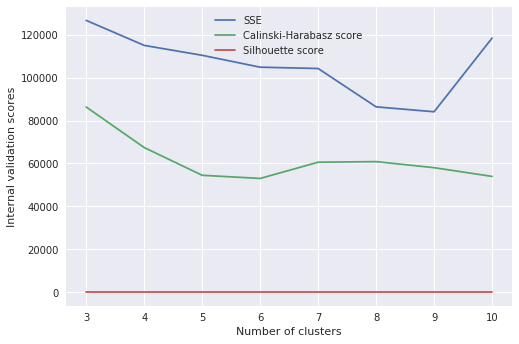

In [23]:
plt.plot(list(sse.keys()), list(sse.values()), label='SSE')
plt.plot(list(chs.keys()), list(chs.values()), label='Calinski-Harabasz score')
plt.plot(list(scs.keys()), list(scs.values()), label='Silhouette score')
plt.xlabel("Number of clusters")
plt.ylabel("Internal validation scores")
plt.legend()

<div align='justify'>In evaluating how good the clusters are, the clusters formed must have low SSE, high Calinski-Harabasz score, and high Silhouette coefficient. For visualization and decision-making purposes, we normalize the validation scores by their maximum value to make proper comparisions and decide the best number of clusters.</div>

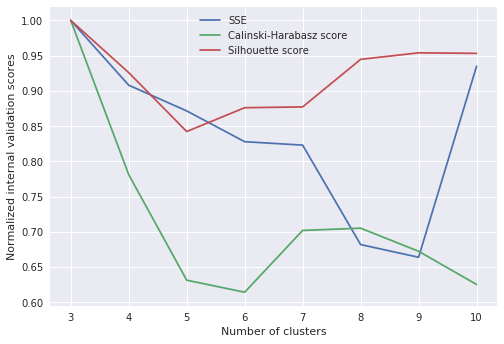

In [27]:
plt.plot(list(sse.keys()), np.array(list(sse.values())) /
         max(sse.values()), label='SSE')
plt.plot(list(chs.keys()), np.array(list(chs.values())) /
         max(chs.values()), label='Calinski-Harabasz score')
plt.plot(list(scs.keys()), np.array(list(scs.values())) /
         max(scs.values()), label='Silhouette score')
plt.xlabel("Number of clusters")
plt.ylabel("Normalized internal validation scores")
plt.legend()

From the plot above, 8 clusters have low SSE while having high CH and Silhouette scores.
After getting the clusters, we can now look at the characteristics of each cluster. In terms of size, the clusters are balanced, except for some clusters with lower but comparable sizes (and one cluster that is very small) as shown in the figure below. 

In [36]:
k = 8
km = kms[k]
counts = pd.Series(km.labels_.compute()).value_counts()

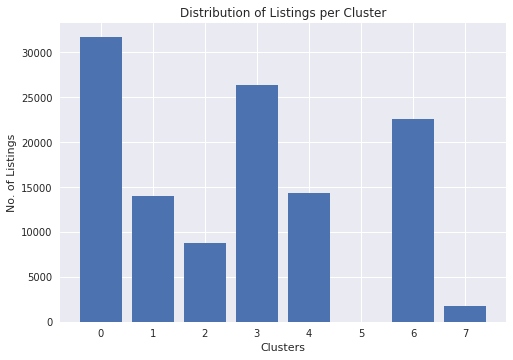

In [35]:
counts_sorted = counts.sort_index()

index = []
val = []

for i, j in enumerate(counts_sorted):
    index.append(i)
    val.append(j)

plt.bar(index, val)
plt.xlabel('Clusters')
plt.ylabel('No. of Listings')
plt.title('Distribution of Listings per Cluster');

Appending the cluster number with the working dataset, we have:

In [29]:
listing3 = pd.concat([listing2.compute().reset_index(),
                      pd.Series(km.labels_.compute())], axis=1)

In [30]:
listing3 = listing3.astype(
    {'accommodates': int, 'bathrooms': float, 'bedrooms': int, 'beds': int})

In [42]:
listing3 = listing3.rename({0:'clusters'}, axis=1)
listing3.to_parquet('s3://bdcc-project-lt6-tin/listing_with_cluster.parquet')

#### Analyzing the obtained clusters

For the numeric features, we can look at the mean and standard deviation for each cluster:

In [31]:
df_num_mean = pd.DataFrame()
df_num_std = pd.DataFrame()

for feat in nums:
    df_num_mean[feat] = listing3[[feat, 0]].pivot(
        columns=0, values=feat).mean(axis=0)
    df_num_std[feat] = listing3[[feat, 0]].pivot(
        columns=0, values=feat).std(axis=0)

In [32]:
df_num_mean['count'] = counts
df_num_mean['percentage'] = (
    100*counts / counts.sum()).round(2).astype(str) + '%'
df_num_std['count'] = counts
df_num_std['percentage'] = (
    100*counts / counts.sum()).round(2).astype(str) + '%'

Mean:

In [34]:
df_num_mean.transpose()

,0,1,2,3,4,5,6,7
accommodates,2.76507,3.25782,3.71125,3.16573,2.72762,4,2.82822,4.27441
bathrooms,1.08089,1.12068,1.19679,1.0836,1.09205,8,1.08695,1.35382
bedrooms,1.00842,1.2551,1.38473,0.988896,1.00539,7.85714,0.847766,1.61953
beds,1.47232,1.84129,2.10495,1.65574,1.49657,3.28571,1.51871,2.51964
count,31716,13963,8814,26387,14296,7,22610,1782
percentage,26.52%,11.68%,7.37%,22.07%,11.96%,0.01%,18.91%,1.49%


Standard deviation:

In [36]:
df_num_std.transpose()

,0,1,2,3,4,5,6,7
accommodates,1.40361,1.41558,1.86751,1.41778,1.44314,5.32291,1.43912,2.82851
bathrooms,0.528764,0.557737,0.686914,0.447081,0.569718,18.5203,0.356849,0.734438
bedrooms,0.811683,0.928982,1.20912,0.803467,0.828598,18.587,0.851118,1.453
beds,0.951458,1.10922,1.41341,1.00764,1.04021,5.61885,0.9725,2.06122
count,31716,13963,8814,26387,14296,7,22610,1782
percentage,26.52%,11.68%,7.37%,22.07%,11.96%,0.01%,18.91%,1.49%


From the numerical features, two clusters stand out - Cluster 5 and Cluster 7. Cluster 5, while only containing 7 listings, represents the extreme listings wherein the number of bathrooms, bedrooms, and beds it has is significantly higher than those other clusters. Cluster 7 is a less extreme version of Cluster 5, which is why it still has 1782 listings. 

On the other end is cluster 6, corresponding to listings with minimal number of rooms, especially bathroom. Its less extreme version is cluster 3. Note that the size of both is still significant, indicative of the huge number of low-end listings.

The remaining clusters are on the average side, with cluster 0 being marginally lower-end while cluster 2 is above average. We can look into more description of the clusters using other features (non-numerical).

In [39]:
df_property_type = pd.DataFrame()
for i in range(k):
    print(f"Cluster {i} - {100*counts.loc[i] / counts.sum():.2f}%")
    freqs = listing3[listing3[0]==i]['property_type'].value_counts()
    freqs /= freqs.sum()
    df_property_type[i] = freqs.head(10)
df_property_type

Cluster 0 - 26.52%
Cluster 1 - 11.68%
Cluster 2 - 7.37%
Cluster 3 - 22.07%
Cluster 4 - 11.96%
Cluster 5 - 0.01%
Cluster 6 - 18.91%
Cluster 7 - 1.49%


,0,1,2,3,4,5,6,7
Apartment,0.920135,0.907971,0.894373,0.913973,0.895425,0.857143,0.913799,0.865320
Condominium,0.025791,0.027358,0.028931,0.028461,0.029938,NaN,0.028395,0.029742
Loft,0.015513,0.020841,0.025301,0.015917,0.015179,NaN,0.013445,0.028058
Boutique hotel,0.011508,0.012963,0.014636,0.013757,0.014619,0.142857,0.014109,0.015713
Serviced apartment,0.006022,0.006374,0.007148,0.005647,0.006226,NaN,0.006192,0.008979
House,0.005801,0.008308,0.012594,0.006897,0.011122,NaN,0.007430,0.029742
Bed and breakfast,0.002617,0.003724,0.002609,0.002956,0.010982,NaN,0.003627,NaN
Guesthouse,0.002459,0.001647,0.001815,0.001857,0.003637,NaN,0.002609,0.002245
Townhouse,0.002302,0.003223,0.004425,0.002388,0.003428,NaN,0.002256,0.011223
Other,0.001860,0.002292,0.002383,0.001971,0.002658,NaN,0.002609,NaN


No significant differences can be observed across clusters for the property type feature. However, the differences in some property types like townhouse (with the proportion being relatively higher for cluster 7) agrees with the observations for the numerical features.

In [40]:
freqs = listing3['room_type'].value_counts()
freqs /= freqs.sum()
freqs.head(10)

Entire home/apt    0.863751
Private room       0.111403
Hotel room         0.015112
Shared room        0.009734
Name: room_type, dtype: float64

In [41]:
df_room_type = pd.DataFrame()

for i in range(k):
    print(f"Cluster {i} - {100*counts.loc[i] / counts.sum():.2f}%")
    freqs = listing3[listing3[0]==i]['room_type'].value_counts()
    freqs /= freqs.sum()
    df_room_type[i] = freqs.head(10)
df_room_type

Cluster 0 - 26.52%
Cluster 1 - 11.68%
Cluster 2 - 7.37%
Cluster 3 - 22.07%
Cluster 4 - 11.96%
Cluster 5 - 0.01%
Cluster 6 - 18.91%
Cluster 7 - 1.49%


,0,1,2,3,4,5,6,7
Entire home/apt,0.893524,0.890138,0.893465,0.884147,0.681030,0.571429,0.882972,0.901235
Private room,0.083995,0.085870,0.085092,0.092394,0.284765,0.428571,0.091287,0.074074
Hotel room,0.013747,0.015040,0.014409,0.015083,0.016648,NaN,0.016320,0.016274
Shared room,0.008734,0.008952,0.007034,0.008375,0.017557,NaN,0.009421,0.008418


Lastly for the room type, except for the usual deviants like cluster 5 (mainly due to its small size), one cluster that hasn't distinguished itself is the middle listing clusters 1 and 4. Cluster 1 here is similar to other, becoming the cluster for all average listings. Cluster 4, on the other hand, has less proportion of it being an entire home or apartment. Unlike other clusters, cluster 4 has a larger percentage of private rooms compared to other clusters.

Now that we have our clusters ready, we can proceed with providing recommendations for each cluster as to what additional amenities to add to make their listings standout.

### Recommender Systems

From each generated clusters, recommendations are given within the clusters. For this project, the utility matrix for the recommendations is constructed from the list of amenities each listing has. What is different from this recommender system is that it only recommends from similar listings with high review scores, since the goal of the project is to find what the low-rated listings are missing. With that, the recommender system will only need the following features from the data (aside from the ID): `amenities` and `review_scores_rating`. The amenities column hold all the necessary information for creating a recommender system while review scores rating will be used to filter and improve the recommendation.

#### Data Loading

In [3]:
fnames = pd.read_csv("4-actualdata.txt", header=None)[0].str.split('data.insideairbnb.com').str[1]

In [4]:
df_rs = dd.read_csv(f"s3://bdcc-project-lt6/data{fnames[0]}/data/listings.csv.gz", compression='gzip',
                    dtype=np.str, assume_missing=True, error_bad_lines=False, blocksize=None, engine='python')

In [5]:
dtypes = {i:np.str for i in df_rs.columns}
dtypes['id'] = np.int64
dtypes['amenities'] = np.str
dtypes['review_scores_rating'] = np.float64

Similar to clustering, the files are read line-by-line while selecting only the relevant columns.

In [7]:

rs_feat = ['id', 'amenities', 'review_scores_rating']
df_rs = dd.read_csv(f"s3://bdcc-project-lt6/data{fnames[0]}/data/listings.csv.gz", compression='gzip',
                    dtype=dtypes, assume_missing=True, error_bad_lines=False, blocksize=None, engine='python')[rs_feat]
failed_files = []
i = 1
for fname in fnames[1:]: #forloop instead of wildcard since different files have different columns
    print(100*i/(len(fnames)-1))
    try:
        df_rs = df_rs.append(dd.read_csv(f"s3://bdcc-project-lt6/data{fname}/data/listings.csv.gz", compression='gzip',
                    dtype=dtypes,
                                         assume_missing=True,
                                         error_bad_lines=False,
                                         blocksize=None, engine='python')[rs_feat])#.set_index("id")
    except Exception as e:
        failed_files.append(f"s3://bdcc-project-lt6/data{fname}/data/listings.csv.gz")
    clear_output(wait=1)
    i += 1

100.0


#### Data Preprocessing

In [8]:
df_rs = df_rs.repartition(npartitions=6)

In [18]:
df_rs = df_rs.groupby("id").last().persist()

In [17]:
df_rs.to_parquet('s3://bdcc-project-lt6-tin/rs.parquet')

In [3]:
df_rs = dd.read_parquet('s3://bdcc-project-lt6-tin/rs.parquet')

To process the amenities, the dask DataFrame is first converted back to a pandas DataFrame and vectorized using CountVectorizer, creating the utility matrix which is saved into a parquet file.

In [13]:
df_amenities = df_rs["amenities"].str.replace('"', '').str.strip('{').str.strip('}').str.split(',').persist()#.head()

In [14]:
df_pd = df_amenities.compute()

In [15]:
cv = CountVectorizer(analyzer=lambda x: x, lowercase=False)

df_utility = cv.fit_transform(df_pd.dropna())

df_utility = pd.DataFrame(df_utility.todense(), columns=cv.get_feature_names(), index=df_pd.dropna().index)

In [16]:
df_utility = dd.from_pandas(df_utility, npartitions=6)

In [16]:
df_utility.to_parquet('s3://bdcc-project-lt6-tin/util.parquet')

In [17]:
df_utility = dd.read_parquet('s3://bdcc-project-lt6-tin/util.parquet')

In [18]:
df_utility.shape[0].compute()

1873305

From the resulting utility matrix, we can look at the frequency distribution of amenities. Most of the listings have 10 to 20 amenities with a few listings having 50 to 70 amenities. Except for a few large scale listings, it can be seen that the standards of listings is to have around 10 to 20 amenities. 

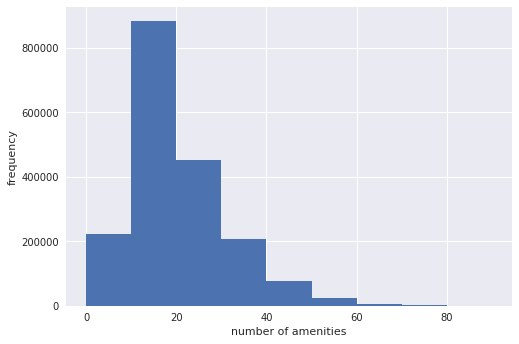

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
freq_amen = df_utility.sum(axis=1).compute()
plt.hist(freq_amen, bins=list(range(0, 100, 10)), histtype='bar', log=False)
plt.xlabel('number of amenities')
plt.ylabel('frequency');

<div align='justify'>Now, we want to see if the number of amenities of a listing affects the review on that listing. If the two are positively correlated, then our recommendations may simply be to continuously add amenities for it to improve, which may make the project uninsightful. If not, what matters is not simply adding new amenities but also which specific amenity to add, which brings the point of our recommender system - suggesting which amenities to add to keep up with the competition.
</div>
<br>
<div align='justify'>
From the plot below, it can be seen that for those listings with very high number of amenities (>80), the reviews are also correspondingly high. This may simply be a small correlation since listings with high number of amenities are heavily invested upon, which can correlate with the care and services for that listing, leading to the high reviews. However, the opposite end (low number of amenities) doesn't say the same thing. That is, for listings with low number of amenities, their review scores are uncorrelated with the number of amenities.
</div>

In [8]:
df_plot = pd.DataFrame()

df_plot['count_amen'] = freq_amen
df_plot['reviews'] = df_rs['review_scores_rating'].compute()

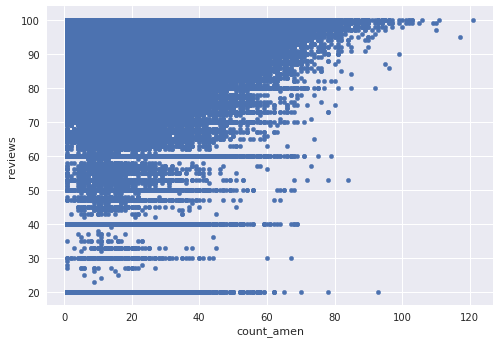

In [12]:
df_plot.plot.scatter('count_amen', 'reviews')

Looking at their overall correlation, we find a 0.1558 correlation between the two variables, indicating a weak relationship.

In [15]:
df_plot.corr().iloc[0, 1]

0.15584052425977038

<div align='justify'>Now, since the recommending listings will be filtered to highly rated listings while the listings to make recommendations to are those with low ratings, we look at the distribution of review scores to make a decision on the threshold of high-rated and low-rated listings. Note that the distribution is in y-log scale so it can be seen that there are significantly large amount of listings with very high reviews (>95). And so, the high-rated listings considered are those with review scores from 95 and above.
</div>
<br>
<div align='justify'>
For the low-rated listings, while the distribution shows that most of them have ratings near 20, we also want to consider those around 40 to 60 since BnB is a very competitive market and having review scores around those range can also be considered low. So the low-rated listings are those with review scores lower than 60.
</div>

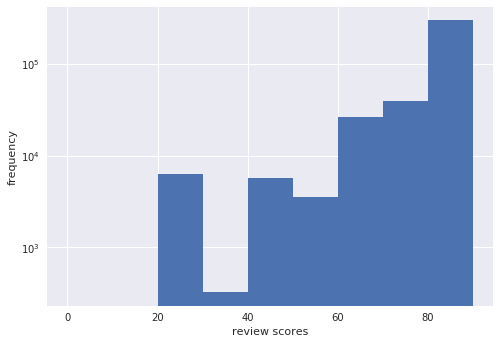

In [16]:
freq = df_rs['review_scores_rating'].dropna().astype(float).compute()
plt.hist(freq, bins=list(range(0, 100, 10)), histtype='bar', log=True)
plt.xlabel('review scores')
plt.ylabel('frequency')

#### Filtering data by Ratings

In [11]:
recommended_users = df_rs['review_scores_rating'][df_rs['review_scores_rating']
                                                  > 95].index.compute()
df_utility_high_rating = df_utility.map_partitions(
    lambda x: x[x.index.isin(recommended_users)]).persist()

In [12]:
low_rating_users = df_rs['review_scores_rating'][df_rs['review_scores_rating']
                                                 < 60].index.compute()
df_utility_low_rating = df_utility.map_partitions(
    lambda x: x[x.index.isin(low_rating_users)]).persist()

In [13]:
df_utility_high_rating.to_parquet(
    's3://bdcc-project-lt6-tin/high-rating.parquet')
df_utility_low_rating.to_parquet(
    's3://bdcc-project-lt6-tin/low-rating.parquet')

Aside from the overall characteristics, we also want to look at the characteristics of the listings per cluster. Specifically, we want to look at the most common amenities in each cluster to see the difference between what we recommend and what is the general amenities for each cluster. But before that, the results from the clustering must be loaded first.

In [163]:
clusters = dd.read_parquet(
    's3://bdcc-project-lt6-tin/listing_with_cluster.parquet')

In [164]:
cluss = sorted(clusters['clusters'].unique())

In [165]:
id_cluss = {}
for clus in cluss:
    id_cluss[clus] = clusters[clusters['clusters']
                              == clus].id.compute().to_list()

In [6]:
with open('clus.json', 'w') as fout:
    json.dump(id_cluss, fout)

#### Looking at amenities per Cluster

After loading the clusters, we investigate the common utilities or amenities per cluster. Specifically, we look at the average value per amenity. Note that the data only displays the presence or absence of an amenity so by taking the average, we get the proportion of the listings for each cluster that has each specific amenity. As can be seen from the heatmap below, the order of the amenities are not necessarily the same but the differences in order across the clusters only vary slightly. This characteristic may be due to how fundamental the amenities are which can be universal and may not vary across clusters. Since the listings are constrained to Paris, amenities like kitchen, heating, and living essentials are always among the top 3, regardless of the cluster. We use a heatmap to look at the ranking of each amenity per cluster where the annotated text corresponds to the ranking.

*Cluster 5 / Ultra high end cluster is ignored due to small size (7 listings), none of which are low-rated.

In [154]:
cluster_names = {0: "Lower-middle", 1: "Middle (entire home)", 2: "Upper-middle", 3: "Low end",
                 4: "Middle (Private rooms)", 5: "Ultra high end", 6: "Ultra low end", 7: "High end"}

In [20]:
clusters = clusters[['id', 'clusters']]

In [157]:
df_util_summary = pd.DataFrame()
for i in cluss:
    if i==5:#cluster 5 is removed for RS since we cannot make recommendations in it due to the small size
        continue 
    df_i = df_utility.map_partitions(lambda x: x[x.index.isin(clusters[clusters['clusters']==i].id)])
    result_i = df_i.mean(axis=0).compute()
    df_util_summary[cluster_names[i]] = result_i.sort_values(ascending=False)[:20]

In [158]:
df_util_summary

,Lower-middle,Middle (entire home),Upper-middle,Low end,Middle (Private rooms),Ultra low end,High end
Kitchen,0.941512,0.945212,0.940663,0.940918,0.908156,0.936400,0.946689
Heating,0.936940,0.933682,0.936238,0.939516,0.928022,0.930694,0.931538
Essentials,0.915689,0.917926,0.919560,0.921893,0.908016,0.922114,0.916386
Wifi,0.865494,0.867006,0.873156,0.868117,0.866046,0.861256,0.872615
Washer,0.747099,0.777698,0.793057,0.761701,0.729715,0.706678,0.767677
Hangers,0.673698,0.669627,0.688337,0.686247,0.654938,0.680142,0.707071
Smoke detector,0.660203,0.667407,0.680281,0.678137,0.664452,0.669084,0.713244
TV,0.641380,0.669484,0.682664,0.660856,0.599538,0.632287,0.670595
Hair dryer,0.638605,0.639619,0.662015,0.643461,0.624021,0.636533,0.690236
Iron,0.633277,0.640908,0.657477,0.644484,0.602406,0.625254,0.678451


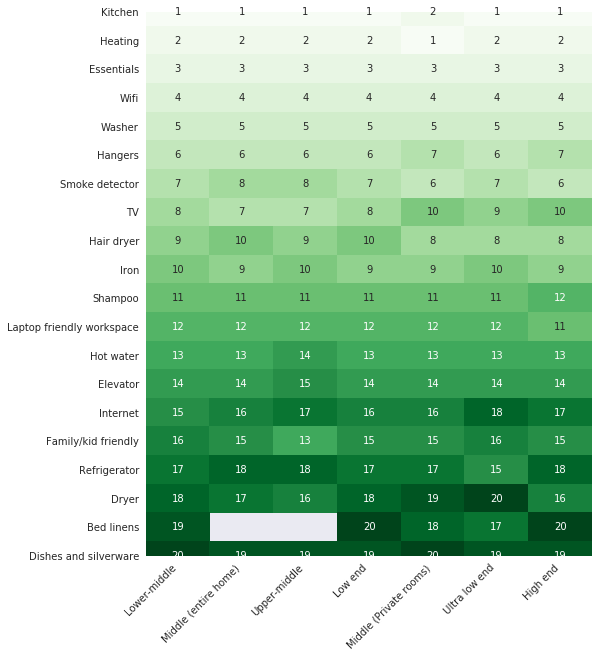

In [180]:
fig,ax = plt.subplots(figsize=(8,10))
hm = sns.heatmap(df_util_summary.rank(ascending=False), cmap='Greens', annot=True, ax=ax, cbar=False);
hm.set_xticklabels(labels=hm.get_xticklabels(), rotation=45, ha='right');

#### User-Based Collaborative Filtering Recommender System

For user-based collaborative filtering recommender system, we have to choose a pre-processing technique and a distance measure to use in order to determine which listings are the nearest neighbors. Note that the utility matrix here has rows equivalent to all the listings, columns for all the amenities, and value of 1 or 0 if the listing has the amenity. We do not perform any pre-processing as the utility matrix already looks like a rounded data due to the implicit nature of the ratings. 

The distance measure used will be Jaccard distance but we must also take into consideration the difference in number of amenities the two listing has. While Jaccard already takes into account the gap between the number of amenities the two listings being compared has, we want to further emphasize the distance two listings will have if they have significant difference in the number of amenities they have. As such, we define the distance measure as:

$$distance = 0.75 \times Jaccard(Amenities_a, Amenities_b) + 0.25 \times \text{abs}\left( \frac{|Amenities_a| - |Amenities_b|}{|Amenities|} \right)$$

where $a$ is a listing with low rating (`review_scores_rating` < 60) while $b$ is a listing with high rating (`review_scores_rating` > 95), $Amenities$ is the set of amenities.

In [161]:
df_utility_high_rating = dd.read_parquet('s3://bdcc-project-lt6-tin/high-rating.parquet')
df_utility_low_rating = dd.read_parquet('s3://bdcc-project-lt6-tin/low-rating.parquet')

In [6]:
N_neigh = 100


def f(x, user): return (0.75*np.abs(x - user).sum() / ((x + user) != 0).sum()
                        + 0.25*np.abs(x.sum() - user.sum()) / len(user))


def recommend_to_user(user):
    idx_neighbors = df_utility_high_rating_clus.apply(f,
                          axis=1,
                          args=(user,),
                          meta=(None, np.float64)).reset_index().set_index(0)
                          .head(N_neigh)

    amen_recom = df_utility_high_rating_clus.map_partitions(
        lambda x: x[x.index.isin(idx_neighbors['id'])]).mean()

    user_amen = user[user == 1].index
#     amen_recom = amen_recom.map_partitions(lambda x: x[~x.index.isin(user_amen)]) #removes amenities existing for the user
# don't remove the amenities already existing for the user. we may need it later (we can remove it later on anyway)

    return amen_recom[amen_recom > 0.2].compute()


delayed_func = delayed(recommend_to_user)

Before doing the recommendation, we first check the number of listings per cluster with low-ratings (<60) and high-ratings (>95):

In [168]:
df_utility_low_rating = df_utility_low_rating.persist()
df_utility_high_rating = df_utility_high_rating.persist()

for i in cluss:
    print(cluster_names[i], "cluster")
    id_clus = id_cluss[i]
    df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
    df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
    print("Low:", df_utility_low_rating_clus.shape[0].compute())
    print("High:", df_utility_high_rating_clus.shape[0].compute(), "\n")

Lower-middle cluster
Low: 229
High: 10099 

Middle (entire home) cluster
Low: 108
High: 4606 

Upper-middle cluster
Low: 72
High: 2801 

Low end cluster
Low: 246
High: 8135 

Middle (Private rooms) cluster
Low: 103
High: 4539 

Ultra high end cluster
Low: 0
High: 2 

Ultra low end cluster
Low: 196
High: 6865 

High end cluster
Low: 9
High: 616 



<div align='justify'>Due to small number of listings on it, no recommendations will be done within the ultra high end cluster. The following set of codes is generating recommendations of amenities per cluster. For each cluster, 100 low-rated listings are given recommendations to at most (if possible). The resulting recommendations are stored into a pickle file for later use. Since the recommendations per user are independent of each other, the code is highly parallelizable. However, doing so for 100 at a time causes killed workers and memory error. So, the recommendations are done 10 users at a time.</div>

In [ ]:
### Cluster 0

In [41]:
id_clus = id_cluss['0']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute().sample(100, random_state=42)
recommend_amenities_clus_0 = {}

for i in range(1, 11): #we do the recommendations 10 users at a time since the dask delayed functions cause a memory error and killed workers otherwise
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results0 = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=6)   
    print(len(results0[0]))
    
    recommend_amenities_clus_0.update(results0[0])

In [8]:
with open('rs_clus0.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_0, f)


In [ ]:
### Cluster 1

In [42]:
id_clus = id_cluss['1']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute().sample(100, random_state=42)
recommend_amenities_clus_1 = {}

for i in range(1, 11):
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=12)   
    
    recommend_amenities_clus_1.update(results[0])

In [8]:
with open('rs_clus1.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_1, f)

In [ ]:
### Cluster 2

In [43]:
id_clus = id_cluss['2']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute()#.sample(100, random_state=42)

recommend_amenities_clus_2 = {}

for i in range(1, 11):
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=12)   
    print(len(results[0]))
    recommend_amenities_clus_2.update(results[0])
    if len(results[0])==0:
        break

In [13]:
with open('rs_clus2.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_2, f)


In [ ]:
### Cluster 3

In [44]:
id_clus = id_cluss['3']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute().sample(100, random_state=42)

recommend_amenities_clus_3 = {}

for i in range(1, 11):
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=12)   

    print(len(results[0]))
    recommend_amenities_clus_3.update(results[0])
    if len(results[0])==0:
        break    

In [8]:
with open('rs_clus3.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_3, f)


In [ ]:
### Cluster 4

In [47]:
id_clus = id_cluss['4']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute().sample(100, random_state=42)

recommend_amenities_clus_4 = {}

for i in range(1, 11):
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=12)   
    

    print(len(results[0]))
    recommend_amenities_clus_4.update(results[0])
    if len(results[0])==0:
        break    

In [8]:
with open('rs_clus4.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_4, f)


In [ ]:
### Cluster 6

In [45]:
id_clus = id_cluss['6']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute().sample(100, random_state=42)

recommend_amenities_clus_6 = {}

for i in range(1, 11):
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=12)       

    print(len(results[0]))
    recommend_amenities_clus_6.update(results[0])
    if len(results[0])==0:
        break    

In [ ]:
with open('rs_clus6.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_6, f)


In [ ]:
### Cluster 7

In [46]:
id_clus = id_cluss['7']
df_utility_low_rating_clus = df_utility_low_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
df_utility_high_rating_clus = df_utility_high_rating.map_partitions(lambda x: x[x.index.isin(id_clus)])
users_100 = df_utility_low_rating_clus.compute()#.sample(100, random_state=42)

recommend_amenities_clus_7 = {}

for i in range(1, 11):
    print(i)
    recommend_i = {}
    for user_id, user in users_100.iloc[(i-1)*10:(i)*10].iterrows():
        recommend_i[user_id] = delayed_func(user)
    results = dask.compute(recommend_i, scheduler='distributed',
                           num_workers=12)   

    print(len(results[0]))
    recommend_amenities_clus_7.update(results[0])
    if len(results[0])==0:
        break    

In [12]:
with open('rs_clus7.pkl', 'wb') as f:
    pickle.dump(recommend_amenities_clus_7, f)



<div align='justify'>One important note here is that due to the difference in the algorithm, the accuracy cannot be measured by comparing if the recommended amenities are already existing in the listing. The listings recommending and being recommended to comes from a different group wherein one is high-rated while one is low-rated. And so, it isn't necessary for the recommended amenities to already be in the set of amenities the low-rated listings has, which is what a high-accuracy recommender system expects.
</div>
<br>
Nonetheless, we can look at the recommended amenities and gather insights from there:

In [51]:
all_clus = {}

for i in [0, 1, 2, 3, 4, 6, 7]:  # skip 5 since it has no low-rated listings
    with open(f'rs_clus{i}.pkl', 'rb') as f:
        clus_i = pickle.load(f)
    all_clus.update(clus_i)

In [54]:
userss = df_rs.map_partitions(lambda x: x[x.index.isin(list(all_clus.keys()))])[
    'amenities'].str.replace('"', '').str.strip('{').str.strip('}').str.split(',').compute()

In [86]:
amen_count = pd.Series()

for user, items in all_clus.items():
    amen_user = userss.loc[user]
    amen_count = amen_count.add(items[(~items.index.isin(amen_user)) & (
        items > 0.5)].index.value_counts(), fill_value=0)

amen_count = amen_count / len(all_clus)

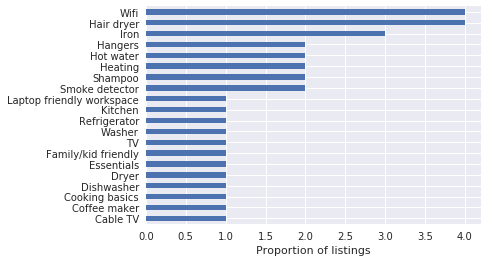

In [182]:
(amen_count.sort_values(ascending=True)[-20:]).plot.barh()
plt.xlabel("Proportion of listings")

By setting a threshold of 50% (i.e. at least half of the similar neighbors has the specific amenity), the overall recommendations across clusters are shown above. Washers, iron, and wifi are most recommended across different clusters. Rather than focusing on these results, we look at the recommendations per cluster and see if it varies from the overall recommendations.

In [170]:
df_recom_summary = pd.DataFrame()
# size of low-rating listings per cluster (if not indicated, size is 100)
cluster_low_rating_sizes = {2: 72, 7: 9}

for i in cluss:
    if i == 5:
        continue
    with open(f'rs_clus{i}.pkl', 'rb') as f:
        clus_i = pickle.load(f)
    userss = df_rs.map_partitions(
        lambda x: x[x.index.isin(list(clus_i.keys()))])
    userss = userss['amenities'].str.replace('"', '').str.strip(
        '{').str.strip('}').str.split(',').compute()
    amen_count = pd.Series()
    for user, items in clus_i.items():
        amen_user = userss.loc[user]
        amen_count = amen_count.add(
            items[(~items.index.isin(amen_user)) & (
                items > 0.5)].index.value_counts(),
            fill_value=0)
    df_recom_summary[cluster_names[i]] = amen_count / \
        cluster_low_rating_sizes.get(i, 100)

In [171]:
df_recom_summary.sort_values(by="Lower-middle", ascending=False)[:20]

,Lower-middle,Middle (entire home),Upper-middle,Low end,Middle (Private rooms),Ultra low end,High end
Wifi,0.24,0.17,0.222222,0.19,0.21,0.26,0.444444
Washer,0.23,0.38,0.375000,0.23,0.26,0.33,0.111111
Iron,0.20,0.29,0.250000,0.14,0.25,0.20,0.333333
Hair dryer,0.19,0.20,0.277778,0.15,0.24,0.22,0.444444
Essentials,0.14,0.11,0.083333,0.16,0.09,0.14,0.111111
Hangers,0.13,0.13,0.125000,0.09,0.07,0.07,0.222222
Heating,0.12,0.10,0.138889,0.11,0.08,0.14,0.222222
Shampoo,0.12,0.12,0.055556,0.07,0.10,0.08,0.222222
Coffee maker,0.10,0.08,0.069444,0.08,0.05,0.05,0.111111
Laptop friendly workspace,0.09,0.11,0.097222,0.07,0.06,0.15,0.111111


Comparing the rankings of the amenities side-by-side with the common amenities per cluster in the heatmap above, we see that what is usually recommended per cluster (right) is different from what is the usual amenity in that cluster (left). This can simply be due to the low-listing amenities already having these amenities but this difference proves that the recommendations and the baseline of the usual amenities is not the same.

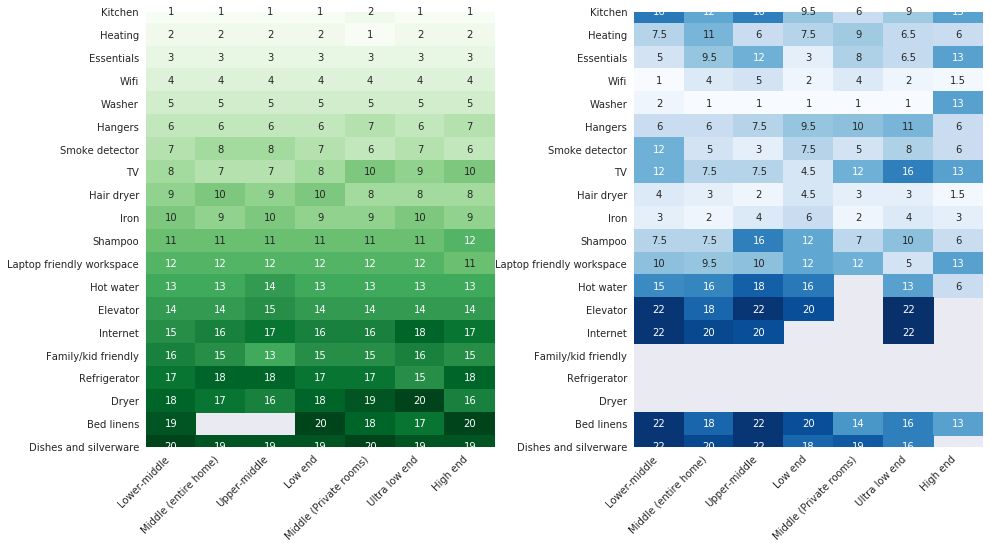

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'wspace': 0.4})

hm1 = sns.heatmap(df_util_summary.rank(ascending=False),
                  ax=ax[0], cmap='Greens', cbar=False, annot=True)
hm2 = sns.heatmap(df_recom_summary.rank(ascending=False).reindex(df_util_summary.rank(
    ascending=False).index), ax=ax[1], cmap='Blues', cbar=False, annot=True)

hm1.set_xticklabels(labels=hm1.get_xticklabels(), rotation=45, ha='right')
hm2.set_xticklabels(labels=hm2.get_xticklabels(), rotation=45, ha='right')

It is interesting to note that amenities like kitchen and essentials, among others, are very common across listings but are not usually recommended. This may be because these amenities are not the key ingredients in achieving a high ranking. This also shows the disparity of high ranking listing to low ranking ones wherein these amenities are not highly valued as they are things that can also be found in low-rated listings. 

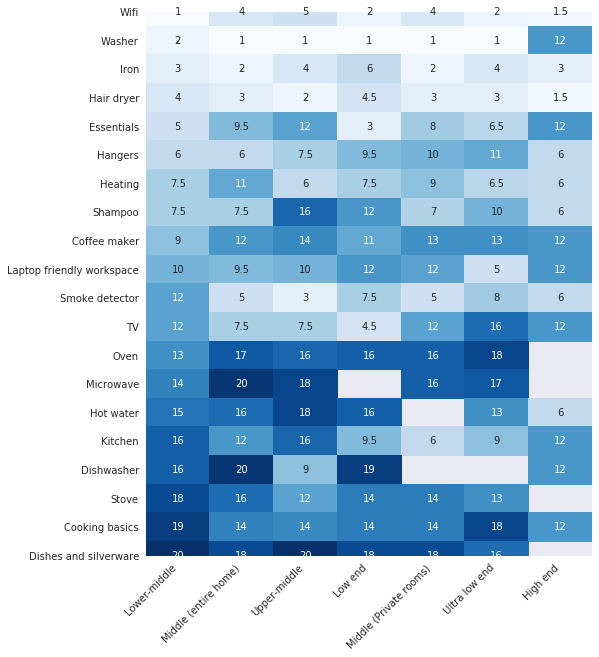

In [185]:
fig, ax = plt.subplots(figsize=(8, 10))
hm = sns.heatmap(df_recom_summary.sort_values(by="Lower-middle", ascending=False)
                 [:20].rank(ascending=False), cmap="Blues", annot=True, cbar=False, ax=ax)
hm.set_xticklabels(labels=hm.get_xticklabels(), rotation=45, ha='right')

Now, looking at the recommendations per cluster in the heatmap below, we can see that the top 5 amenities per cluster is usually similar, except for the high-end cluster. Due to the scale of the listings under the high-end cluster, it is expected for these listings to already contain essentials like washers, which is also the reason why the washer is ranked 12 among its recommended amenities. Regardless of scale of the listings, what is commonly missing for low-rated listings are `WiFi`, `Hair dryer`, and `Iron`, amenities which cannot be said as completely necessary but is very much desired by customers. Another interesting observation is the `Essentials` which is ranked highly for the lower to middle-end listings but ranked lowly for larger-scale listings. This is consistent with what we found since essentials is usually already available so it is not usually recommended for the higher-end listings. Other similarities and differences can be observed from the plot above like kitchen being relatively highly ranked for middle-end private rooms. 

For all visualizations and analysis done above, the recommender system is still personalized, i.e. it is done at a per listings level. The aggregation per cluster is only done for analysis and visualization purposes.

## Conclusions

<br>
<div align='justify'>In this study, we were able to identify eight (8) clusters of listings based on the type and size of the property. No definitive name of clusters can be defined but based on the summary statistics of the features used, we obtained groupings based on the size of the listings. The number of listings per cluster were somehow balanced except for Cluster 5 with only 7 listings, representing the extreme listing with significantly larger property size compared to others. The clusters obtained are shown below including its defined characteristics:
 
<br>

- Cluster 0: Lower-middle end
- Cluster 1: Middle end (entire home)
- Cluster 2: Upper-middle end
- Cluster 3: Low end
- Cluster 4: Middle end (Private rooms)
- Cluster 5: Ultra high end
- Cluster 6: Ultra low end
- Cluster 7: High end
    

Additionally, we were able to provide a personalized recommender system at a listing level which can determine what amenities to add to that listing based on its similar high-rated listings. It was found out that what the low-rated listings lack are the amenities that the customers very much want to have that would give them comfort and this possibly give them the reason why they are far beyond being high-rated one.    
</div>

## Recommendations

<br>
<div align='justify'>For future studies, we recommend to look at analyzing how the price or rating of the listings would change after implementing the recommended amenity. This would help the owners determine which amenity to add and a monetary value could be given to show how much more the hosts, and even Airbnb itself, would earn from the recommender system. We also recommend to make general recommender system able to cater to listings from any country or city especially those which are not commonly visited by tourists to help the hosts find ways on how to further improve their listings.
</div>
<br>
<div align='justify'>In terms of optimizing the system, we recommend to explore other features to be used in clustering as this plays an important role in grouping the listings. There might be some features not used in this study which could clearly define the difference between the clusters formed and would give better recommendations. </div>

## References / Acknowledgement



We would like to acknowledge Prof. Christian Alis, Prof. Madhavi, and Prof. Eduardo David, Jr. for mentoring us throughout the course and imparting their knowledge in our journey to become a Data Scientist.

<a id='contact'></a>
<div>
<h2>Contact Us</h2>
</div><br>
Justine Buno: jbuno@aim.edu<br/>
Elijah Justin Medina: emedina@aim.edu<br/>
Raphael Mari Ongleo: rongleo@aim.edu<br/>